### Price Prediction (V3)
Ziel: Das Model soll als Input eine 20 Einheiten lange Folge an Marktdaten entgegennehmen und dann einen Preis als Output zurückgeben. Sogesehen nämlich den Einundzwanzigste. Das ist die seq_length. <br> Zudem hat unser Input 4 rows, welche die Features sind. Die rows haben die features (open, high, low, close). Als Output brauchen wir aber nur ein Feature, nämlich den close-price.

#### Imports
Als erstes importiere ich alles was wir brauchen. Als deep learning lybrary verwende ich pytorch und für das preprocessing verwende ich den StandardScaler und MinMaxScaler von sklearn.

In [1]:
from os import listdir
import random
from xmlrpc.client import boolean
from numpy.core.records import array
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.nn.modules import loss
import eikon as ek
import math
from threading import Event
from datetime import datetime, date
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

#### Datenverarbeitung
Jetzt beginne ich mit dem ersten Schritt beim maschine Learning und deep Learning. Unzwar das Datenverarbeiten. Dazu importiere ich die Daten des S&P 500 index, welcher den Markt gut wiederspiegelt. Eine Reihe besteht aus den Tageseröffnungspreise, dem Höchstpreis, dem Tiefstpreis und dem Tagesschlusspreis eines jeden Tages. Da die Börse am Wochenende nicht offen ist, werden am Wochenende auch keine Kurse gestellt. Also gibt es an diesen Tagen keine Preise.
Die Daten habe ich vorher von Datastream heruntergeladen. Datastream stellt sehr genaue und schon gereinigte Marktdaten bereit und somit habe ich den ersten Punkt der Datenverarbeitung schon erledigt. <br>Nach dem importieren der Daten muss ich diese aber noch in das richtige Format bringen. Die Daten müssen scaliert und dann in Tensoren umgewandelt werden. 

In [2]:
def getDataFromCSV(path):
    data = pd.read_csv(path, index_col="Date", parse_dates=True)
    return data

df = getDataFromCSV(r"C:\Users\jensb\Documents\Praktikum\Stock_Prediction\03-07-2021\JugendForscht\CSVs\SPX.csv")
print(len(df))
X = df.iloc[:-1, :]#InputData
y = pd.DataFrame(df["CLOSE"][1:])#TargetData

print("Die Daten des S&P: ")
print(df)

1768
Die Daten des S&P: 
               OPEN     HIGH      LOW    CLOSE
Date                                          
2015-01-02  2058.90  2072.36  2046.04  2058.20
2015-01-05  2054.44  2054.44  2017.34  2020.58
2015-01-06  2022.15  2030.25  1992.44  2002.61
2015-01-07  2005.55  2029.61  2005.55  2025.90
2015-01-08  2030.61  2064.08  2030.61  2062.14
...             ...      ...      ...      ...
2022-01-03  4778.14  4796.64  4758.17  4796.56
2022-01-04  4804.51  4818.62  4774.27  4793.54
2022-01-05  4787.99  4797.70  4699.44  4700.58
2022-01-06  4693.39  4725.01  4671.26  4696.05
2022-01-07  4697.66  4707.95  4662.74  4677.03

[1768 rows x 4 columns]


Zum scalieren der InputData benutzen wir den StandardScaler von sklearn, der unsere Daten standarisiert, indem er den Mittelwert entfernt und die Daten mithilfe ihrer Streung verdichtet.<br>
Zum scalieren der TargetData benutzen wir den MinMaxScaler der unsere Daten in eine Zahl zwischen 0 und 1 scaliert. Das ist nützlich da uns das Netz als Output/Prediction auch eine Zahl zwischen 0 und 1 ausgeben wird und wenn wir die TargetData nicht scalieren würden, wäre der Loss sehr groß und wir wollen ja unseren Loss minimieren. 

In [3]:
mm = MinMaxScaler(feature_range=(0,1))
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm =mm.fit_transform(y)

X_batches = []
y_batches = []
for i in range(20, len(X_ss)):
    X_batches.append(X_ss[i-20:i])
    y_batches.append(y_mm[i-1, :])

X_batches = np.array(X_batches)
y_batches = np.array(y_batches)

X_train = X_batches[:1600, :]
X_test = X_batches[1600:, :]

y_train = y_batches[:1600, :]
y_test = y_batches[1600:, :]

print("Training Shape: ", X_train.shape, y_train.shape)
print("Testing Shape: ", X_test.shape, y_test.shape) 

Training Shape:  (1600, 20, 4) (1600, 1)
Testing Shape:  (147, 20, 4) (147, 1)


Alles was ich hier mache ist die Daten richtig zu teilen. Also für eine 40 Einheiten lange Reihe in den Input Daten, habe ich eine 1 Einheit lange Reihe in der Target Data. <br>Dann scaliere ich diese Daten noch. Die Input Daten mit dem StandardScaler und die Output Daten mit dem MinMaxScaler. <br>Danach teile ich die Daten noch in Test- und Trainingssets ein. Dabei ist das Trainingsset deutlich größer als das Testset. Auch das verringert den Loss, da so unser Model mehr lernt. Beim testen lernt unser Model nicht.

In [4]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

print("Training Tensor Shape: ", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Tensor Shape: ", X_test_tensors.shape, y_test_tensors.shape)

Training Tensor Shape:  torch.Size([1600, 20, 4]) torch.Size([1600, 1])
Testing Tensor Shape:  torch.Size([147, 20, 4]) torch.Size([147, 1])


Hier habe ich die Daten nur noch in Tensoren umgewandelt, sodass das Model diese auch verarbeiten kann. <br> Wenn man auf die From der Tensoren guckt, so sind sie in der Form:<br>(batch_size, seq_length, features)<br>(1600, 20, 4)<br>
Genau so soll das auch sein, denn wenn wir auf pytorch in die Dokumentation für LSTM-Layer gucken, so sehen wir, dass genau so auch der Input aussehen soll.<br>
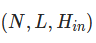 <br>
Legende:<br>
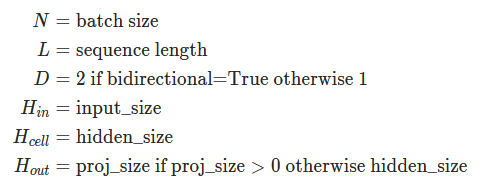 <br>
Dabei ist die Input_size und unsere Features das Gleiche.

#### Model / Netz
Der nächste Schritt ist das Model zu erstellen. Wie schon bemerkt besteht das Model aus einem LSTM-Layer. Zudem besteht es auch noch aus zwei fully connected Layern. Diese werden auch Dense-Layer oder Linear-Layer genannt. Zudem benutzen wir noch die RELU-Funktion als Aktivierung-Funktion, die so aussieht:

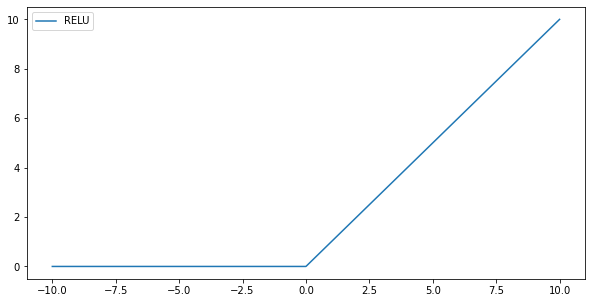

In [5]:
a = np.linspace(-10, 10, 1000)#x
b = np.maximum(0, a)#y

plt.figure(figsize=(10, 5))
plt.plot(a, b)
plt.legend(['RELU'])
plt.show()

Für x>0 ist die RELU-Funktion x (linear). Für x<=0 gibt sie 0 zurück. Das hilft dabei, dass die Predictions nicht negative Preise herrausgeben, aber dennoch nicht verändert werden, da die Funktion den gleichen Wert für x>0 zurückgibt.

In [6]:
class Netz(nn.Module):
    def __init__(self, outputs, inputs, hiddens, layers, seq_length):
        super(Netz, self).__init__()
        self.outputs = outputs#Features des Outputs
        self.inputs = inputs #Features des Inputs
        self.hiddens = hiddens#Anzahl der Hiddens für das LSTM
        self.layers = layers#Anzahl der LSTM-Layers
        self.seq_length = seq_length#Die Länge der Reihe der Input Daten

        self.lstm1 = nn.LSTM(input_size=inputs, hidden_size=hiddens, num_layers=layers, batch_first=True)
        self.fc1 = nn.Linear(hiddens, 128)
        self.fc2 = nn.Linear(128, outputs)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        h_0 = self.initHiddenInternal(x)#initial hidden state
        c_0 = self.initHiddenInternal(x)#initial cell state
        output, (hn, cn) = self.lstm1(x, (h_0, c_0))
        hn = hn[-1]
        hn = hn.view(-1, self.hiddens)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
    def initHiddenInternal(self, x):
        return Variable(torch.zeros(self.layers, x.size(0), self.hiddens))

In der `__init__` Funktion initalisiere ich alle Layer und Variablen die ich später, für das Training und Testen brauchen. Diese Funktion wird beim Zuweisen der Klasse gleich aufgerufen. <br>
Als nächstes haben wir die forward und initHiddenInternal Funktionen. In die forward-Funktion geben wir unseren Input als x rein. Mit der Größe/Form von x werden dann erstmal die hidden_state und cell_state initalisiert. <br>
Für die hidden_state und cell_state kriegen wir zurück: (2, 1600, 30) in der Form (1 * num_layers, batch_size, num_hiddens)
Die 2 steht für die Anzahl an LSTM-Layern mal eins, da unser Model nur in eine Direktion geht, die 1600 passt zu unserer vorher schon festgelegten batch_size und die 30 gibt die Anzahl an Hiddens wieder. Die Anzahl an Hiddens sind hier noch nicht bestimmt, können aber später fast frei gewählt werden.<br>
Vergleicht man das wieder mit der pytorch Dokumentation so sieht man das alles zusammen passt:<br>
Für die initial hidden_state: <br>
Für die initial cell_state:  <br>

Zum Vergleich hier nochmal die Legende:<br>
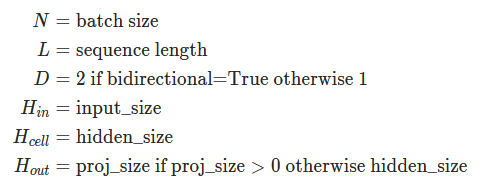 <br>

Wie Ihnen vielleicht schon aufgefallen ist passen die hidden_state und cell_state nicht ganz zueinander, da H/out und H/cell nicht das gleiche sind. Bei diesem Model jedoch schon. Denn H/cell gibt die Anzahl der Hiddens wieder und H/out gibt eigentlich die projection_size wieder. Diese ist bei diesem Model 0 und somit gibt H/out auch die Anzahl der Hiddens zurück. Da deswegen H/out und H/cell doch gleich sind kann man auch beide mit der gleichen Funktion initalisieren. Diese Funktion ist die initHiddenInternal-Funktion, die einen Tensor aus Nullen zurück gibt, welcher schon in der richtigen Form, die oben besprochen wurde, ist. <br><br>
Betrachten Sie die forward-Funktion, so sieht man auch einen Vorteil an pytorch, nämlich den dynamic computation graph. Was so besonders an diesem Graphen ist, ist dass man in der forward Funktion durch eine if-Abfrage ganz einfach den Verlauf ändern kann. Das verwende ich in diesem Model/Netz nicht, aber für mich war es so auch einfacher deep learning zu lernen und verstehen.
<br><br>
Als nächstes muss das Netz/Model initalisiert werden um es zu trainieren. Dazu müssen auch noch ein paar Variablen festgelegt werden. Eine davon ist die schon erwähnte Anzahl der Hiddens.

In [7]:
num_epochs = 140 #Anzahl der Epochen
learning_rate = 0.001 #Lernrate

inputs = 4 #Features des Inputs
hiddens = 30#Festlegung der Anzahl der Hiddens des LSTMs
layers = 2#Anzahl der LSTM-Layers
outputs = 1#Anzahl der Output Features
seq_length = X_train_tensors.shape[0]#Die Länge der Reihe der Input Daten

model = Netz(outputs, inputs, hiddens, layers, seq_length)#Initalisieren des Models/Netzs

Beschreibung der Variablen:
<ul>
<li>Die Anzahl der Epochen ist die Anzahl wie oft das Model trainiert. </li>
<li>Die Lernrate gibt an wie stark die Weights beim Backwardpass minimiert werden sollen, um den Loss des Models zu verringern. Die Lernrate hat viel mit overfitting zu tun. Ist sie zu hoch, so kann es sein, dass das Model das Minimum vom Loss verfehlt. Pytorch bietet die Möglichkeit beim Trainieren die Lernrate zu vergrößern/verkleinern, doch das habe ich hier erstmal nicht implementiert, da es logisch für mich keinen Sinn macht, da jede Batch gleich wichtig ist.</li>
<li>Wie schon erklärt sind die Features des Inputs (open, high, low, close), also 4 insgesamt.</li>
<li>Als Anzahl der Hiddens des LSTMs habe ich 30 genommen. Diese Zahl muss man einfach festlegen und durch Ausprobieren merkt man wie sich die Anzahl an Hiddens auf den Loss auswirkt. Am Anfang habe ich 10 Hiddens genommen, dann 120 als Maximum und habe mich dann immer mehr an den Optimalen Loss angenähert. Natürlich kann man nicht jede Anzahl an Hiddens ausprobieren, da das Model Zeit zum Trainieren braucht. Das ist auch die einzige Grenze für die Anzahl der Hiddens. Die Zeit und die Kapazität der GPU/CPU.</li>
<li>Die Anzahl der LSTM-Layers wirkt sich stark auf den Loss aus. Sie bestimmt wie viele LSTMCells hintereinander verwendet werden. 2 oder 1 Layer ist/sind am besten für dieses Model/Netz.</li>
<li>Die seq_length kennen Sie ja bereits. Ich habe sie nur nicht hardgecoded, da ich so besser mit ihr experimentieren kann und wie sie sich auf den Loss auswirkt.</li>
</ul>
Dann initlisiere ich das Model/Netz mit den Variablen und jetzt ist es fertig für das Training.

#### Training

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

lossData = []
def train(epoch):
    model.train()
    optimizer.zero_grad()
    output = model.forward(X_train_tensors)
    loss = criterion(output, y_train_tensors)
    loss.backward()
    optimizer.step()
    lossData.append(loss.item())
    print("Epoch: %d, loss: %1.5f" % (epoch + 1, loss.item()))

for i in range(num_epochs):
    train(i)

Epoch: 1, loss: 0.10974
Epoch: 2, loss: 0.10082
Epoch: 3, loss: 0.09270
Epoch: 4, loss: 0.08528
Epoch: 5, loss: 0.07833
Epoch: 6, loss: 0.07176
Epoch: 7, loss: 0.06555
Epoch: 8, loss: 0.05971
Epoch: 9, loss: 0.05433
Epoch: 10, loss: 0.04942
Epoch: 11, loss: 0.04498
Epoch: 12, loss: 0.04097
Epoch: 13, loss: 0.03739
Epoch: 14, loss: 0.03423
Epoch: 15, loss: 0.03149
Epoch: 16, loss: 0.02911
Epoch: 17, loss: 0.02704
Epoch: 18, loss: 0.02523
Epoch: 19, loss: 0.02362
Epoch: 20, loss: 0.02217
Epoch: 21, loss: 0.02079
Epoch: 22, loss: 0.01940
Epoch: 23, loss: 0.01795
Epoch: 24, loss: 0.01637
Epoch: 25, loss: 0.01466
Epoch: 26, loss: 0.01286
Epoch: 27, loss: 0.01104
Epoch: 28, loss: 0.00932
Epoch: 29, loss: 0.00774
Epoch: 30, loss: 0.00635
Epoch: 31, loss: 0.00515
Epoch: 32, loss: 0.00416
Epoch: 33, loss: 0.00334
Epoch: 34, loss: 0.00270
Epoch: 35, loss: 0.00222
Epoch: 36, loss: 0.00191
Epoch: 37, loss: 0.00175
Epoch: 38, loss: 0.00174
Epoch: 39, loss: 0.00185
Epoch: 40, loss: 0.00204
Epoch: 41

Als erstes muss man für das Training das criterion und den optimizer festlegen.<br>
Was das criterion macht ist, dass es den output und die Target-Data nimmt und mit diesen berechnet wie weit der output/Prediction von den reelen Daten entfernt ist.<br>

Mit `model.train()` sagt man dem Model, dass es lernen kann. Die Gegenfunktion ist `model.eval()`. Ist das Model auf eval eingestellt so lernt es nicht sonder produziert nur ein Ergebnis. Da jetzt das Model aber trainieren/lernen soll, stellen wir es auf train. <br> 
Dann müssen wir die Gradienten des Optimizers noch auf 0 stellen. Das ist eine Art Reset für den Optimizer, da dieser sonst die Gradienten der letzten Epoche verwendet und das würde das Lernen behingern und den Loss vergrößern.<br>
Danach schicken wir unsere Input-Trainings-Tensoren durch die forward-Funktion des Models und speichern den vom Model auf diese Daten produzierten Output in der Variable output.<br>
Dann berechnet man den Loss mithilfe des criterions.<br>
Der Loss würd dann in den Backwardpass gegeben. Was dabei passiert ist, dass Graph mit Bezug auf die Verluste und Variablen differenziert wird.<br>
`optimizer.step()` aktualisiert die Weights des Models.

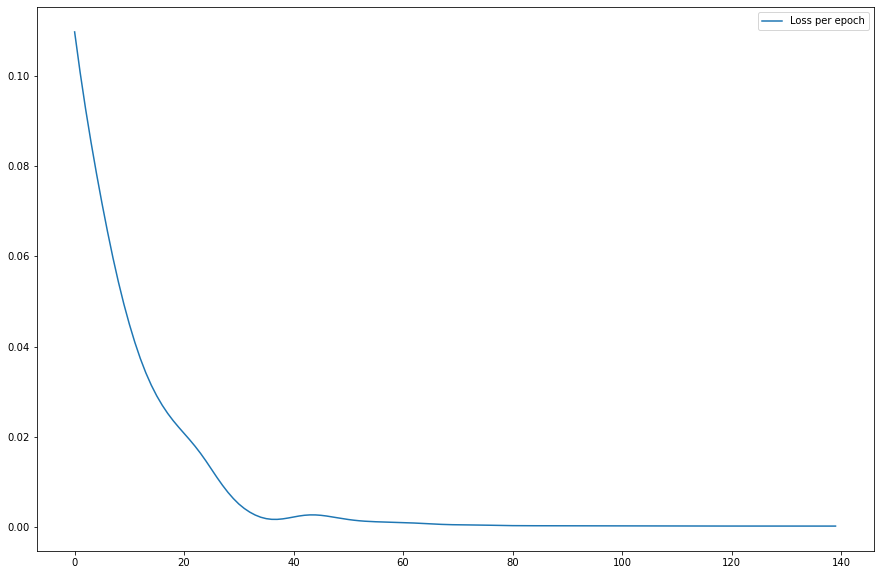

In [9]:
def plotLoss():
    plt.figure(figsize=(15, 10))
    plt.plot(lossData, label="Loss per epoch")
    plt.legend()
    plt.show()
    
plotLoss()

#### Optimieren
Hier habe ich den Loss auf der y-Achse und die Epochen auf der x-Achse. Dieser Graph ist sehr wichtig für das Arbeiten mit deep learning Netzen, da man hier den Verlauf des Loss sehen kann und daraus seine Schlüsse ziehen kann. <br>
Bei ca. 30 Epochen kann man sehr gut ein locales Minimum erkennen, dass dann aber überwunden wurde. Bei 40 Epochen gab es nochmal ein locales Minimum. Außerdem kann man mit diesem Graphen seine Lernrate besser regulieren. Da dieser Graph sehr "hügelig" ist würde ich die Lernrate noch etwas verringern und dann wieder gucken, wie sich der Graph verändert hat. Ansonsten bin ich aber sehr zufrieden mit einem loss von 0.00029. Je kleiner das Loss wird, desto wichtiger ist es diese letzten Punkte/Verbesserungen herrauszuholen um das Loss so klein wie möglich zu bekommen.

#### Testen

Loss:  0.002116817282512784


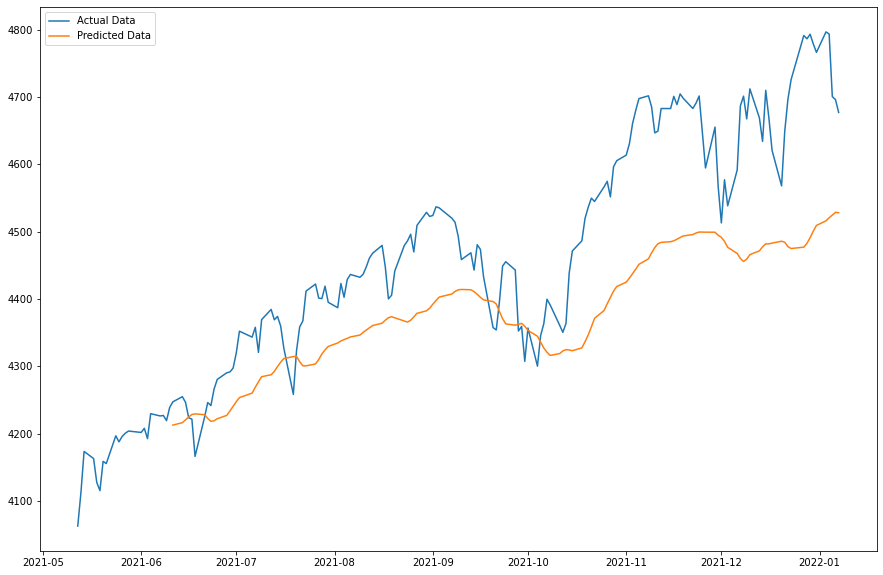

In [10]:
def test(plotting : boolean):
    #Test our Model with Test Data
    optimizer.zero_grad()
    train_predict = model(X_test_tensors)
    loss = criterion(train_predict, y_test_tensors)
    print("Loss: ", loss.item())
    train_predict = mm.inverse_transform(train_predict.data.numpy()).flatten().tolist()
    a = [np.nan] * (len(df) - len(train_predict))
    train_predict = a + train_predict
    df["Predicted Testing Data"] = train_predict
    if plotting:
        plt.figure(figsize=(15,10))
        plt.plot(df["CLOSE"][1600:], label="Actual Data")
        plt.plot(df["Predicted Testing Data"][1600:], label="Predicted Data")
        plt.legend()
        plt.show()

test(plotting=True)

Hier nochmal der ganze Graph:

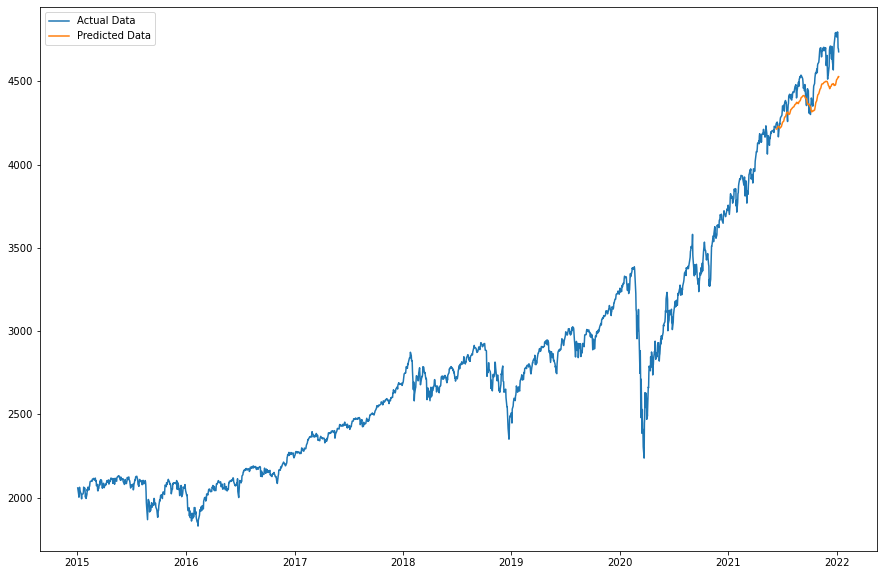

In [11]:
plt.figure(figsize=(15,10))
plt.plot(df["CLOSE"], label="Actual Data")
plt.plot(df["Predicted Testing Data"], label="Predicted Data")
plt.legend()
plt.show()

#### Auswertung

Ein Loss von gerundet 0,0032 ist schon sehr gut. Doch vergleicht man die Kurve der vorhergesagten Preise mit der Kurve der reelen Daten, so fallen zwei Dinge sofort auf:
<ul>
    <li>Die Kurve der vorhergesagten Preise verläuft unterhalb der Kurve der reelen Daten.</li>
    <li>Die Kurve der vorhergesagten Preise läuft der Kurve der reelen Daten hinterher.</li>
</ul>
Das hört sich erstmal nicht so gut an. Um diese Probleme zu beheben und sich die Ausmaße der Probleme besser vorstellen zu können, habe ich die Veränderung geplotet. Dadurch sieht man nur um wie viel sich der Preis zu dem Preis des Vortages verändert hat. Das mache ich mit beiden Kurven. Dann gucke ich mir das wieder an.

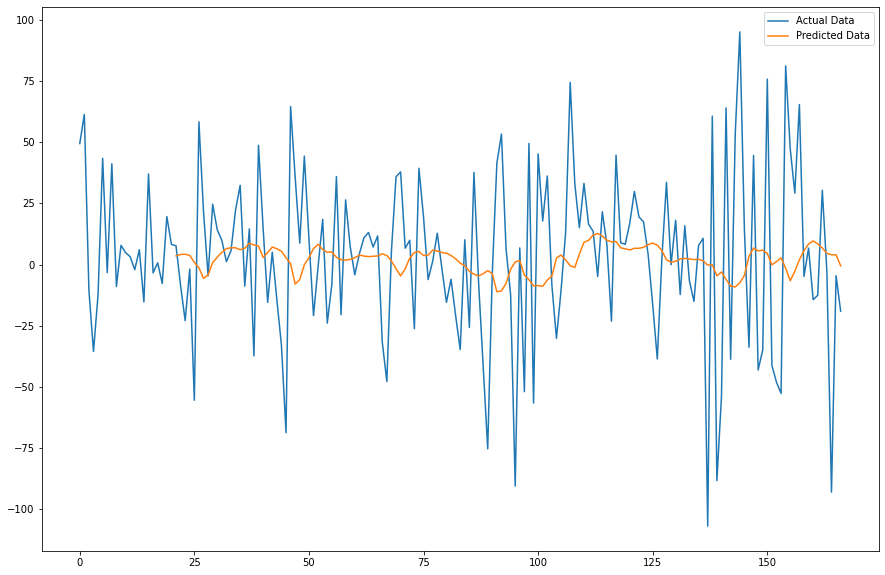

In [18]:
close_change = []
predicted_change = []
for i in range(1601, len(df)):
    close_change.append(df["CLOSE"][i]-df["CLOSE"][i-1])
    predicted_change.append(df["Predicted Testing Data"][i]-df["Predicted Testing Data"][i-1])

plt.figure(figsize=(15,10))
plt.plot(close_change, label="Actual Data")
plt.plot(predicted_change, label="Predicted Data")
plt.legend()
plt.show()

Auf diesem Plot sieht man erstmal nicht so viel, deswegen muss man die Preise der reelen Daten noch ,,glätten". Das mache ich im nächsten Plot mit einem exponentiell gleitenden Durchschnitt.

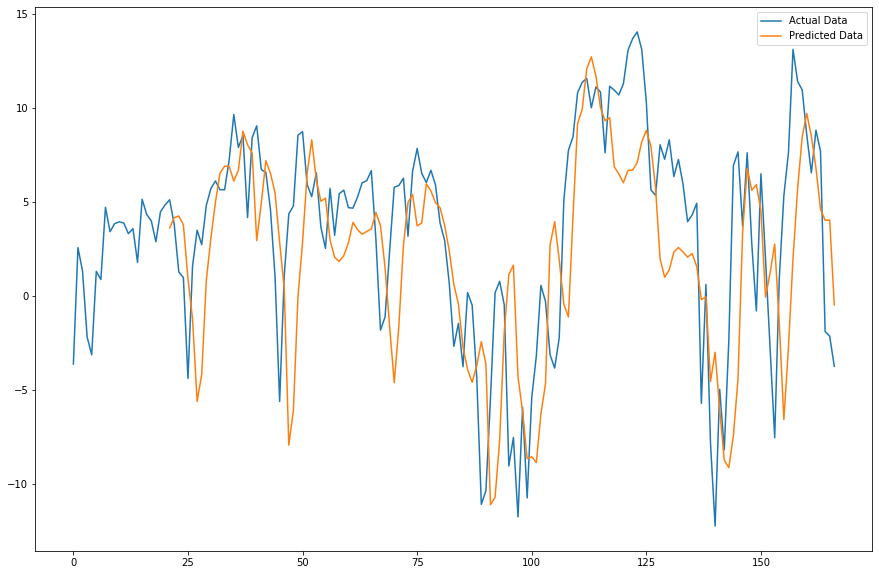

In [19]:
df["EMA"] = df["CLOSE"].ewm(span=20, adjust=False).mean()
ema_change = []
predicted_change = []
for i in range(1601, len(df)):
    ema_change.append(df["EMA"][i]-df["EMA"][i-1])
    predicted_change.append(df["Predicted Testing Data"][i]-df["Predicted Testing Data"][i-1])

plt.figure(figsize=(15,10))
plt.plot(ema_change, label="Actual Data")
plt.plot(predicted_change, label="Predicted Data")
plt.legend()
plt.show()

Das ganze sieht doch schon viel besser aus. Das einzige was ich gemacht habe ist einen exponentiell gleitenden Durchschnitt mit dem Interval von 20 über die Tagesschlusspreise gelegt. Die nun geglätteten Preise und die vorhergesagten Preise passen schon besser zueinander. Damit haben wir das erste Problem erledigt. Denn das Problem, dass die vorhergesagten Preise unterhalb der reelen Preise verläuft existiert in dieser Ansicht nicht mehr. Das zweite Problem besteht zudem aber noch und das lässt sich nicht so einfach lösen. Die vorhergesagten Preise laufen den reelen Preisen hinterher. Das muss aber gar nicht so stark ein Problem sein, wie es einem jetzt erstmal vorkommt. Wir legen das Ziel des Models einfach anders aus. Das Model soll nichmehr die künftige Marktentwicklung prognostizieren, sondern soll warten bis sich ein Trend etabliert und ihm dann folgen. Das gute an dieser Lösung ist, dass man das Model nicht anpassen muss, da man einfach das Ziel an das Model anpasst. 

#### Fehlerbetrachtung
Ich hatte immer mal wieder kleine Probleme mit meinem Programm, konnte diese aber relativ schnell lösen. Einen großes Problem hatte ich jedoch.
Wenn wir nochmal die forward-Funktion des Netzes betrachtet, so ist Ihnen vielleicht schon aufgefallen, dass wir aus lstm1 drei Variablen herrausbekommen. Den output, die hidden states und die cell states. 
<code>
def forward(self, x):
        h_0 = self.initHiddenInternal(x)#initial hidden state
        c_0 = self.initHiddenInternal(x)#initial cell state
        output, (hn, cn) = self.lstm1(x, (h_0, c_0))
        hn = hn[-1]
        hn = hn.view(-1, self.hiddens)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out
</code>